In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#importa las librerias de los modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

In [2]:
data_path_file='DelayedFlights.csv'
df = pd.read_csv(data_path_file)

In [3]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

El modelo que nos ocupa trata de determinar si un vuelo que ya ha despegado llegará con retraso, es decir si **'ArrDelay'>0**

Al haber despegado, conocemos el retraso que sufrio en la salida: **'DepDelay'**

**'Taxi-In'**: Tiempo entre el aterrizaje y el acople a la boarding gate. Se elimina por data leakage.

**'Taxi-Out'**: Tiempo entre dejar el parking y despegar, se incluye en las variables a considerar.

Eliminaremos las columnas **'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'** por Data Leakage, pues introducen informacion del retraso en la llegada del vuelo cuando aun desconocemos si existirá dicho retraso.

Como el vuelo no ha llegado en el momento de estimar su retraso, no dispondremos de **'ArrTime', 'ActualElapsedTime'** ni **'Airtime'**

Las columnas **'Cancelled', 'CancellationCode'** tambien seran eliminadas pues obviamente el vuelo no ha sido cancelado.

La derivacion del vuelo acarrea un retraso fuera de la consideracion del modelo por lo que tambien se descarta **'Diverted'**

Esto deja las siguientes variables en el dataframe

In [4]:
features=['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'CRSArrTime',
          'CRSElapsedTime', 'TaxiOut', 'ArrDelay', 'DepDelay', 'Distance', 'UniqueCarrier']

In [5]:
X= df[features]

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Month           int64  
 1   DayofMonth      int64  
 2   DayOfWeek       int64  
 3   DepTime         float64
 4   CRSDepTime      int64  
 5   CRSArrTime      int64  
 6   CRSElapsedTime  float64
 7   TaxiOut         float64
 8   ArrDelay        float64
 9   DepDelay        float64
 10  Distance        int64  
 11  UniqueCarrier   object 
dtypes: float64(5), int64(6), object(1)
memory usage: 177.3+ MB


Dada la variablidad en los retrasos entre aerolineas **solo haremos el analisis para una de ellas.** Como el dataset es amplio aun con esta eleccion seguiremos disponiendo de una cantidad de informacion considerable.

Escogemos la **Aerolinea US** que constituye el 5% de los vuelos.

In [7]:
X = X[ X['UniqueCarrier'] == 'US' ]
X.drop( columns= 'UniqueCarrier', inplace= True )
X.shape

(98425, 11)

**'Arrdelay' no ha de tener faltantes.** tratandose de un numero relativamente bajo descartaremos las filas con 'ArrDelay' faltantes para toda la matriz de caracteristicas X

In [8]:
nodelay = ~(X['ArrDelay'].isnull())
X= X[nodelay]
X.shape

(98007, 11)

Realizamos un analisis del coeficiente de correlacion lineal sobre las variables

<AxesSubplot:>

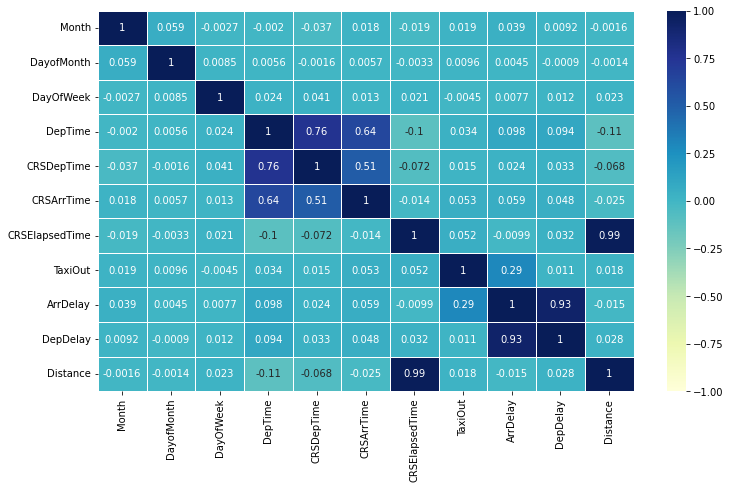

In [9]:
X.corr()
plt.figure(figsize=(12,7))
sns.heatmap(X.corr().round(4),  annot=True, linewidths=.5,  vmin=-1, vmax=1,  cmap="YlGnBu")

Observamos una fuerte correlacion lineal ente **'ArrDelay'** y **'DepDelay'**

**'TaxiOut'** tambien muestra cierta relacion lineal con la variable objetivo

Guardamos en la variable **y** un panda.Series en la que indicamos si el vuelo ha tenido retraso. Es decir si **'ArrDelay'>0** Eliminaremos de la matriz de caracteristicas X la variable **'ArrDelay'**

In [10]:
y= X['ArrDelay'] > 0
X.drop( columns='ArrDelay', inplace= True )
X.shape

(98007, 10)

In [11]:
y.head()

81557     True
81558     True
81559    False
81560     True
81561    False
Name: ArrDelay, dtype: bool

Transformamos **y** tal que las 2 clases serán: 
* 0: Vuelo sin retraso
* 1: Vuelo con retraso

In [12]:
y_list= y.tolist()
y_list= [int(x) for x in y_list ]
y= pd.Series(y_list)

In [13]:
y.head()

0    1
1    1
2    0
3    1
4    0
dtype: int64

In [14]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance
81557,1,1,2,1925.0,1855,2114,139.0,16.0,30.0,646
81558,1,1,2,152.0,146,917,331.0,14.0,6.0,2551
81559,1,1,2,1407.0,1400,1514,74.0,14.0,7.0,227
81560,1,1,2,2206.0,2142,2300,258.0,16.0,24.0,1747
81561,1,1,2,1453.0,1440,1703,143.0,13.0,13.0,665


**Mutual information** es un indice que mide cuanto se reduce la incertidumbre sobre el conocimiento de una variable al conocer el valor de otra. 

In [15]:
mi_scores = mutual_info_classif(X, y)
[ '{:.4f}'.format(x) for x in mi_scores]

['0.0031',
 '0.0011',
 '0.0031',
 '0.0149',
 '0.0087',
 '0.0113',
 '0.0103',
 '0.0256',
 '0.1109',
 '0.0132']

Dada su escasa correlacion lineal y el bajo valor en mutual information con la variable de interes descartamos  **'Month', 'DayofMonth', 'DayOfWeek'**

Por tanto las caracteristicas de la matrix X seran las contenidas en la lista **feat_X**

In [16]:
feat_X=['DepTime', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'TaxiOut', 'DepDelay', 'Distance']
X= X[feat_X]
X.shape

(98007, 7)

In [17]:
X.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance
81557,1925.0,1855,2114,139.0,16.0,30.0,646
81558,152.0,146,917,331.0,14.0,6.0,2551
81559,1407.0,1400,1514,74.0,14.0,7.0,227
81560,2206.0,2142,2300,258.0,16.0,24.0,1747
81561,1453.0,1440,1703,143.0,13.0,13.0,665


In [18]:
X.describe().round(3)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance
count,98007.000,98007.000,98007.000,98007.000,98007.000,98007.000,98007.000
mean,1497.971,1483.483,1629.792,161.242,20.581,38.760,965.938
std,501.830,464.627,515.184,86.591,15.052,46.989,711.482
min,1.000,5.000,1.000,24.000,1.000,6.000,90.000
25%,1127.000,1120.000,1257.000,92.000,12.000,11.000,397.000
50%,1544.000,1525.000,1717.000,128.000,16.000,21.000,665.000
75%,1913.000,1845.000,2046.000,225.000,24.000,47.000,1515.000
max,2400.000,2359.000,2359.000,426.000,325.000,886.000,2979.000


In [19]:
# Dividimos los datos (X,y) en training y test (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(78405, 7) (19602, 7) (78405,) (19602,)


Para mejorar la convergencia del modelo LogisticRegression es necesario standarizar.

**Standarizamos** ambos dataframes: **X_train, X_test**

In [20]:
#Iniciamos una instancia de StandardScaler
scaler = preprocessing.StandardScaler()

In [21]:
# Fit to TRAIN data. Then transform it.
M_train = scaler.fit_transform(X_train)
#Volvemos a meter la matriz en dataframe
X_train = pd.DataFrame(M_train, columns= feat_X )

# Transform TEST data 
M_test = scaler.transform(X_test)
#Volvemos a meter la matriz en dataframe
X_test= pd.DataFrame(M_test, columns= feat_X )

In [22]:
y_train.value_counts()/len(y_train)*100

1    84.939736
0    15.060264
dtype: float64

Se define como **Null Accuracy** la precision que obtendriamos estimando la clase mas frecuente. En este caso seria del 84.93%!!

En general interesa un modelo con alta precision. Existen otras metricas cuyo resultado dependera de las decisiones que tomemos. Segun estas decisiones los falsos negativos y falsos positivos variaran.

Tomaremos la decision de **maximizar los TP** (true positives) y **minimizar los FN** (falsos negativos) frente a los FP (falsos positivos). Desde un punto de vista practico estimar un retraso y que no se produzca puede percibirse como una ventaja. Pero no predecir un retraso que se produce puede suponer un problema.

----------------------

## Ejercicio 1

Crea almenos 3 modelos de clasificacion diferentes para predecir si ha habido retraso en los vuelos de acuerdo a los datos contenidos en el dataset.

--------------------------

Crearemos los siguientes modelos de Clasificacion con sus parametros por defecto:

* **Regresion Logistica** : log_reg
* **Decission Tree** : dec_tree
* **XGBoost** : xgb_clas

Tambien los entrenaremos y haremos predicciones a partir de los datos de test

In [23]:
# Crea una instancia del modelo de Regresion Logistica usando los parametros por defecto
log_reg = LogisticRegression()

# Entrena el modelo con los datos de train
log_reg.fit(X_train,y_train)

# Realiza las predicciones a partir de los datos de test
y_log_pred = log_reg.predict(X_test)

In [24]:
# Init classifier
dec_tree = DecisionTreeClassifier()

# Train modelo with train data
dec_tree.fit(X_train,y_train)

# Realiza las predicciones
y_tree_pred = dec_tree.predict(X_test)

In [25]:
# Init classifier
xgb_clas = xgb.XGBClassifier(use_label_encoder=False)

# Fit model
xgb_clas.fit(X_train, y_train)

# Predict
y_xgb_pred = xgb_clas.predict(X_test)

[15:18:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Modelo SVM. Prescindiremos del modelo por tardar excesivamente en entrenarlo. SVM no se recomienda para datasets grandes.

El modelo K-Neighbors tampoco se recomienda para datasets grandes.

In [26]:
# Create a svm Classifier
# svm_clas = svm.SVC()
# Train the model using the training sets
# svm_clas.fit(X_train, y_train)
# Predict the response for test dataset
# y_svm_pred = svm_clas.predict(X_test)

------------------------

## Ejercicio 2

Compara los modelos de clasificacion usando los siguientes parametros:

* **Precision** (Accuracy)
* **Matriz de Confianza**
* **Otras metricas**: Precision and Recall

In [27]:
log_conf_M = metrics.confusion_matrix(y_test, y_log_pred)
tree_conf_M = metrics.confusion_matrix(y_test, y_tree_pred)
xgb_conf_M = metrics.confusion_matrix(y_test, y_xgb_pred)

print('Matrices de Confianza:')
print('Logistic Regression: ')
print(log_conf_M)

print('Decision Tree: ')
print(tree_conf_M)

print('XGBoost: ')
print(xgb_conf_M)

Matrices de Confianza:
Logistic Regression: 
[[ 1120  1817]
 [  696 15969]]
Decision Tree: 
[[ 1525  1412]
 [ 1518 15147]]
XGBoost: 
[[ 1564  1373]
 [  820 15845]]


In [28]:
acc_log = round(metrics.accuracy_score(y_test, y_log_pred),4)
pre_log = round(metrics.precision_score(y_test, y_log_pred),4)
rec_log = round(metrics.recall_score(y_test, y_log_pred),4)
                
acc_tree = round(metrics.accuracy_score(y_test, y_tree_pred),4)
pre_tree = round(metrics.precision_score(y_test, y_tree_pred),4)  
rec_tree = round(metrics.recall_score(y_test, y_tree_pred),4)
                
acc_xgb = round(metrics.accuracy_score(y_test, y_xgb_pred),4)
pre_xgb = round(metrics.precision_score(y_test, y_xgb_pred),4)
rec_xgb = round(metrics.recall_score(y_test, y_xgb_pred),4)


print("Log Reg. | Accuracy:", acc_log, ' | ', "Precision:", pre_log, ' | ', "Recall:", rec_log)
print("Dec Tree | Accuracy:", acc_tree,' | ', "Precision:", pre_tree,' | ', "Recall:", rec_tree)
print("XGBoost  | Accuracy:", acc_xgb, ' | ', "Precision:", pre_xgb, ' | ', "Recall:", rec_xgb)

Log Reg. | Accuracy: 0.8718  |  Precision: 0.8978  |  Recall: 0.9582
Dec Tree | Accuracy: 0.8505  |  Precision: 0.9147  |  Recall: 0.9089
XGBoost  | Accuracy: 0.8881  |  Precision: 0.9203  |  Recall: 0.9508


Con los parametros por defecto el orden de los modelos de mejor a peor segun los criterios establecidos **max(TP) y min(FN)** seria: Logistic regresion, XGBoost y Decision Tree.

---------------

## Ejercicio 3

Entrena los modelos usando los diferentes parametros que admiten.

------------------

* **XGBoost**:

In [29]:
xgb_clas2 = xgb.XGBClassifier(use_label_encoder=False, booster= 'gbtree',
                              n_estimators=1000, max_depth=7, learning_rate=0.1, 
                              gamma= 0.1, objective= 'binary:logistic', eval_metric='logloss',
                              random_state=33, verbosity=0, n_jobs=4, )

xgb_clas2.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])


[0]	validation_0-logloss:0.63057
[1]	validation_0-logloss:0.57920
[2]	validation_0-logloss:0.53631
[3]	validation_0-logloss:0.50027
[4]	validation_0-logloss:0.46945
[5]	validation_0-logloss:0.44303
[6]	validation_0-logloss:0.42025
[7]	validation_0-logloss:0.40039
[8]	validation_0-logloss:0.38316
[9]	validation_0-logloss:0.36809
[10]	validation_0-logloss:0.35468
[11]	validation_0-logloss:0.34290
[12]	validation_0-logloss:0.33272
[13]	validation_0-logloss:0.32357
[14]	validation_0-logloss:0.31554
[15]	validation_0-logloss:0.30832
[16]	validation_0-logloss:0.30197
[17]	validation_0-logloss:0.29594
[18]	validation_0-logloss:0.29077
[19]	validation_0-logloss:0.28611
[20]	validation_0-logloss:0.28194
[21]	validation_0-logloss:0.27818
[22]	validation_0-logloss:0.27460
[23]	validation_0-logloss:0.27168
[24]	validation_0-logloss:0.26891
[25]	validation_0-logloss:0.26624
[26]	validation_0-logloss:0.26395
[27]	validation_0-logloss:0.26200
[28]	validation_0-logloss:0.26033
[29]	validation_0-loglos

[238]	validation_0-logloss:0.22399
[239]	validation_0-logloss:0.22396
[240]	validation_0-logloss:0.22394
[241]	validation_0-logloss:0.22396
[242]	validation_0-logloss:0.22392
[243]	validation_0-logloss:0.22391
[244]	validation_0-logloss:0.22386
[245]	validation_0-logloss:0.22380
[246]	validation_0-logloss:0.22384
[247]	validation_0-logloss:0.22377
[248]	validation_0-logloss:0.22377
[249]	validation_0-logloss:0.22375
[250]	validation_0-logloss:0.22376
[251]	validation_0-logloss:0.22376
[252]	validation_0-logloss:0.22379
[253]	validation_0-logloss:0.22378
[254]	validation_0-logloss:0.22378
[255]	validation_0-logloss:0.22378
[256]	validation_0-logloss:0.22379
[257]	validation_0-logloss:0.22377
[258]	validation_0-logloss:0.22377
[259]	validation_0-logloss:0.22377


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [30]:
# Predict
y_xgb2_pred = xgb_clas2.predict(X_test)

xgb2_conf_M = metrics.confusion_matrix(y_test, y_xgb2_pred)

print('XGBoost: ')
print(xgb_conf_M)
print('XGBoost 2: ')
print(xgb2_conf_M)

acc_xgb2 = round(metrics.accuracy_score(y_test, y_xgb2_pred),4)
pre_xgb2 = round(metrics.precision_score(y_test, y_xgb2_pred),4)
rec_xgb2 = round(metrics.recall_score(y_test, y_xgb2_pred),4)

print("XGBoost  | Accuracy:", acc_xgb, ' | ', "Precision:", pre_xgb, ' | ', "Recall:", rec_xgb)
print("XGBoost2 | Accuracy:", acc_xgb2,' | ', "Precision:", pre_xgb2,' | ', "Recall:", rec_xgb2)


XGBoost: 
[[ 1564  1373]
 [  820 15845]]
XGBoost 2: 
[[ 1576  1361]
 [  801 15864]]
XGBoost  | Accuracy: 0.8881  |  Precision: 0.9203  |  Recall: 0.9508
XGBoost2 | Accuracy: 0.8897  |  Precision: 0.921  |  Recall: 0.9519


Obtenemos mejora en el modelo XGBoost2. TP=15864 y FN=801. Vemos como tenemos mejora en accuracy, precision y recall

Observemos un histograma de predicciones para una muestra aleatoria de casos extraidos de la matriz de datos de entreno X_train

In [31]:
s= X_train.sample(10000)
prob_s= xgb_clas2.predict_proba(s)[:,1]
type(prob_s)

numpy.ndarray

<AxesSubplot:ylabel='Count'>

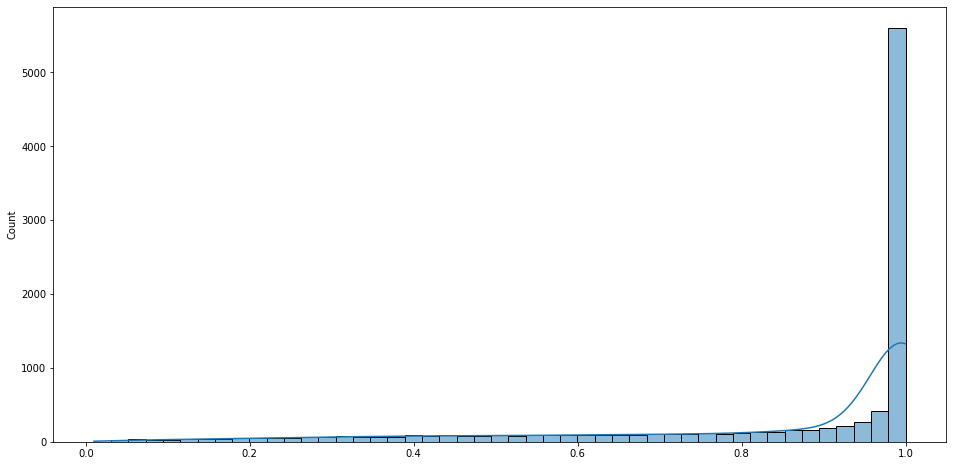

In [32]:
plt.figure(figsize=(16,8))
sns.histplot(data=prob_s, kde=True)

Observamos como el **threshold** entre casos no esta proximo al valor 0.5 sino que esta muy desplazado a la derecha.

<AxesSubplot:ylabel='Count'>

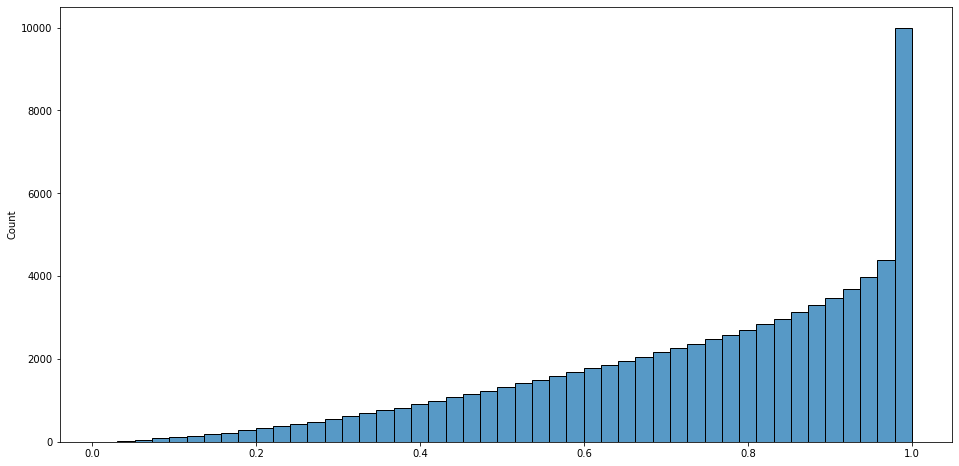

In [33]:
plt.figure(figsize=(16,8))
sns.histplot(data=prob_s, cumulative=True)

Modifiquemos el **threshold** del modelo para ver si podemos mejorar las predicciones.

In [34]:
xgb_clas3 = xgb.XGBClassifier(use_label_encoder=False, booster= 'gbtree',
                              n_estimators=1000, max_depth=7, learning_rate=0.1, 
                              gamma= 0.1, objective= 'binary:logistic', eval_metric='logloss',
                              random_state=33, verbosity=0, n_jobs=4,
                             base_score=0.75 )

xgb_clas3.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.42590
[1]	validation_0-logloss:0.40390
[2]	validation_0-logloss:0.38523
[3]	validation_0-logloss:0.36906
[4]	validation_0-logloss:0.35500
[5]	validation_0-logloss:0.34302
[6]	validation_0-logloss:0.33257
[7]	validation_0-logloss:0.32336
[8]	validation_0-logloss:0.31513
[9]	validation_0-logloss:0.30779
[10]	validation_0-logloss:0.30136
[11]	validation_0-logloss:0.29558
[12]	validation_0-logloss:0.29039
[13]	validation_0-logloss:0.28573
[14]	validation_0-logloss:0.28172
[15]	validation_0-logloss:0.27808
[16]	validation_0-logloss:0.27468
[17]	validation_0-logloss:0.27148
[18]	validation_0-logloss:0.26882
[19]	validation_0-logloss:0.26642
[20]	validation_0-logloss:0.26439
[21]	validation_0-logloss:0.26238
[22]	validation_0-logloss:0.26057
[23]	validation_0-logloss:0.25895
[24]	validation_0-logloss:0.25720
[25]	validation_0-logloss:0.25573
[26]	validation_0-logloss:0.25438
[27]	validation_0-logloss:0.25336
[28]	validation_0-logloss:0.25222
[29]	validation_0-loglos

[238]	validation_0-logloss:0.22456
[239]	validation_0-logloss:0.22455
[240]	validation_0-logloss:0.22459
[241]	validation_0-logloss:0.22458
[242]	validation_0-logloss:0.22461
[243]	validation_0-logloss:0.22465
[244]	validation_0-logloss:0.22462
[245]	validation_0-logloss:0.22461
[246]	validation_0-logloss:0.22459
[247]	validation_0-logloss:0.22455
[248]	validation_0-logloss:0.22459


XGBClassifier(base_score=0.75, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [35]:
# Predict
y_xgb3_pred = xgb_clas3.predict(X_test)

xgb3_conf_M = metrics.confusion_matrix(y_test, y_xgb3_pred)

print('XGBoost 2: ')
print(xgb2_conf_M)
print('XGBoost 3: ')
print(xgb3_conf_M)

acc_xgb3 = round(metrics.accuracy_score(y_test, y_xgb3_pred),4)
pre_xgb3 = round(metrics.precision_score(y_test, y_xgb3_pred),4)
rec_xgb3 = round(metrics.recall_score(y_test, y_xgb3_pred),4)

print("XGBoost2 | Accuracy:", acc_xgb2, ' | ', "Precision:", pre_xgb2, ' | ', "Recall:", rec_xgb2)
print("XGBoost3 | Accuracy:", acc_xgb3, ' | ', "Precision:", pre_xgb3, ' | ', "Recall:", rec_xgb3)

XGBoost 2: 
[[ 1576  1361]
 [  801 15864]]
XGBoost 3: 
[[ 1550  1387]
 [  825 15840]]
XGBoost2 | Accuracy: 0.8897  |  Precision: 0.921  |  Recall: 0.9519
XGBoost3 | Accuracy: 0.8872  |  Precision: 0.9195  |  Recall: 0.9505


Aunque el histograma esta muy sesgado a la derecha, el valor de threshold de probabilidad de 0.5 nos da los mejores valores de TP y FN que deseamos, por lo que xgb_clas2 seria mejor modelo que xgb_clas3

* **DecissionTreeClassifier**:

In [36]:
# Init classifier
dec_tree2 = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=60, min_samples_leaf=20)

# Train modelo with train data
dec_tree2.fit(X_train,y_train)

y_tree2_pred = dec_tree2.predict(X_test)

In [37]:
tree2_conf_M = metrics.confusion_matrix(y_test, y_tree2_pred)

print('Decision Tree: ')
print(tree_conf_M)
print('Decision Tree 2: ')
print(tree2_conf_M)

acc_tree2 = round(metrics.accuracy_score(y_test, y_tree2_pred),4)
pre_tree2 = round(metrics.precision_score(y_test, y_tree2_pred),4)  
rec_tree2 = round(metrics.recall_score(y_test, y_tree2_pred),4)

print("Dec Tree   | Accuracy:", acc_tree, ' | ', "Precision:", pre_tree, ' | ', "Recall:", rec_tree)
print("Dec Tree 2 | Accuracy:", acc_tree2,' | ', "Precision:", pre_tree2,' | ', "Recall:", rec_tree2)


Decision Tree: 
[[ 1525  1412]
 [ 1518 15147]]
Decision Tree 2: 
[[ 1378  1559]
 [ 1035 15630]]
Dec Tree   | Accuracy: 0.8505  |  Precision: 0.9147  |  Recall: 0.9089
Dec Tree 2 | Accuracy: 0.8677  |  Precision: 0.9093  |  Recall: 0.9379


Obtenemos mejoras en todos los indices.

* **LogisticRegression**:


In [38]:
# Crea una instancia del modelo de Regresion Logistica 
log_reg2 = LogisticRegression(penalty='elasticnet', solver='saga',  tol=0.0001,
                             max_iter=200, l1_ratio=0.8, C=0.05,
                             verbose=2, random_state=33)

# Entrena el modelo con los datos de train
log_reg2.fit(X_train,y_train)

# Realiza las predicciones a partir de los datos de test
y_log2_pred = log_reg2.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [39]:
log_conf_M2 = metrics.confusion_matrix(y_test, y_log2_pred)

print('Conf Matrix Log Regr : ')
print(log_conf_M)

print('Conf Matrix Log. Regr 2: ')
print(log_conf_M2)

acc_log2 = round(metrics.accuracy_score(y_test, y_log2_pred),4)
pre_log2 = round(metrics.precision_score(y_test, y_log2_pred),4)
rec_log2 = round(metrics.recall_score(y_test, y_log2_pred),4)

print("Log Reg   | Accuracy:", acc_log, ' | ', "Precision:", pre_log, ' | ', "Recall:", rec_log)
print("Log Reg 2 | Accuracy:", acc_log2,' | ', "Precision:", pre_log2,' | ', "Recall:", rec_log2)

Conf Matrix Log Regr : 
[[ 1120  1817]
 [  696 15969]]
Conf Matrix Log. Regr 2: 
[[ 1062  1875]
 [  654 16011]]
Log Reg   | Accuracy: 0.8718  |  Precision: 0.8978  |  Recall: 0.9582
Log Reg 2 | Accuracy: 0.871  |  Precision: 0.8952  |  Recall: 0.9608


Para el conjunto de test obtenemos mas TP y menos FN, que es justo el objetivo que nos habiamos fijado. Asi que segun el interés fijado el modelo log_reg2 obitiene mejor resultado que log_reg

------------------

## Ejercicio 4

Compara el rendimiento usando train_test() o Cross Validation

----------------

Otro uso del cross validation **CV** es no apartar un conjunto de test y realizar la evaluacion de performance del modelo con CV. El resultado final para el modelo concreto será la media de los resultados obtenidos. Tambien se podrá dar información sobre la variablidad de las evaluaciones. 

In [40]:
#Iniciamos una instancia de StandardScaler para todos los datos X
scaler2 = preprocessing.StandardScaler()

In [41]:
# Fit to ALL data. Then transform it.
M = scaler2.fit_transform(X)

# Guardamos la matriz en el dataframe X0
X0 = pd.DataFrame(M, columns= feat_X )

In [42]:
print('X0:', X0.shape,'|  y:',y.shape)

X0: (98007, 7) |  y: (98007,)


In [43]:
# Crea una instancia del modelo de Regresion Logistica usando los parametros por defecto
log_reg0 = LogisticRegression()

my_scoring = ['accuracy', 'precision', 'recall']
log_scores = cross_validate(log_reg0, X0, y, cv=5, scoring=my_scoring)

acc_log0_mean = round(log_scores['test_accuracy'].mean(),6)
acc_log0_std= round(log_scores['test_accuracy'].std(),6)
pre_log0_mean= round(log_scores['test_precision'].mean(),6)
pre_log0_std= round(log_scores['test_precision'].std(),6)
rec_log0_mean= round(log_scores['test_recall'].mean(),6)
rec_log0_std= round(log_scores['test_recall'].std(),6)

print("Log Reg Test Set | Accuracy:", acc_log, ' | ', "Precision:", pre_log, ' | ', "Recall:", rec_log)

#print(log_scores)
print('All Data Cross Validation Results:')
print('mean accuracy: ', acc_log0_mean, '| std dev:', acc_log0_std )
print('mean precision:', pre_log0_mean, '| std dev:',pre_log0_std)
print('mean recall:   ', rec_log0_mean, '| std dev:', rec_log0_std)

Log Reg Test Set | Accuracy: 0.8718  |  Precision: 0.8978  |  Recall: 0.9582
All Data Cross Validation Results:
mean accuracy:  0.872458 | std dev: 0.004712
mean precision: 0.899203 | std dev: 0.002408
mean recall:    0.957183 | std dev: 0.006716


In [44]:
# Init classifier
dec_tree0 = DecisionTreeClassifier()

tree_scores = cross_validate(dec_tree0, X0, y, cv=5, scoring=my_scoring)

acc_tree0_mean = round(tree_scores['test_accuracy'].mean(),6)
acc_tree0_std= round(tree_scores['test_accuracy'].std(),6)
pre_tree0_mean= round(tree_scores['test_precision'].mean(),6)
pre_tree0_std= round(tree_scores['test_precision'].std(),6)
rec_tree0_mean= round(tree_scores['test_recall'].mean(),6)
rec_tree0_std= round(tree_scores['test_recall'].std(),6)

#print(tree_scores)
print("Dec Tree Test Set| Accuracy:", acc_tree,' | ', "Precision:", pre_tree,' | ', "Recall:", rec_tree)
print('All Data Cross Validation Results:')
print('mean accuracy: ', acc_tree0_mean, '| std dev:', acc_tree0_std )
print('mean precision:', pre_tree0_mean,'| std dev:', pre_tree0_std )
print('mean recall:   ', rec_tree0_mean, '| std dev:', rec_tree0_std)

Dec Tree Test Set| Accuracy: 0.8505  |  Precision: 0.9147  |  Recall: 0.9089
All Data Cross Validation Results:
mean accuracy:  0.845838 | std dev: 0.007132
mean precision: 0.911329 | std dev: 0.001768
mean recall:    0.906764 | std dev: 0.008702


In [45]:
# Init classifier
xgb_clas0 = xgb.XGBClassifier(use_label_encoder=False)

xgb_scores = cross_validate(xgb_clas0, X0, y, cv=5, scoring=my_scoring)

acc_xgb0_mean = round(xgb_scores['test_accuracy'].mean(),6)
acc_xgb0_std= round(xgb_scores['test_accuracy'].std(),6)
pre_xgb0_mean= round(xgb_scores['test_precision'].mean(),6)
pre_xgb0_std= round(xgb_scores['test_precision'].std(),6)
rec_xgb0_mean= round(xgb_scores['test_recall'].mean(),6)
rec_xgb0_std= round(xgb_scores['test_recall'].std(),6)

#print(xgb_scores)
print("XGBoost Test Set | Accuracy:", acc_xgb, ' | ', "Precision:", pre_xgb, ' | ', "Recall:", rec_xgb)
print('All Data Cross Validation Results:')
print('mean accuracy: ', acc_xgb0_mean, '| std dev:',acc_xgb0_std )
print('mean precision:', pre_xgb0_mean,'| std dev:',pre_xgb0_std )
print('mean recall:   ', rec_xgb0_mean, '| std dev:', rec_xgb0_std )

XGBoost Test Set | Accuracy: 0.8881  |  Precision: 0.9203  |  Recall: 0.9508
All Data Cross Validation Results:
mean accuracy:  0.884621 | std dev: 0.005271
mean precision: 0.918297 | std dev: 0.005608
mean recall:    0.948668 | std dev: 0.008633


----------------------

## Ejercicio 5

Realiza algun proceso de ingenieria de variables para mejorar la predicción.

-------------------------

Observemos un histograma de **CRSElapsedTime** dividido segun si han tenido retraso los vuelos o no. Segun los datos se estima una forma de distribucion de probabilidad. Se observan formas diferentes en ambos casos.

<AxesSubplot:xlabel='CRSElapsedTime', ylabel='Count'>

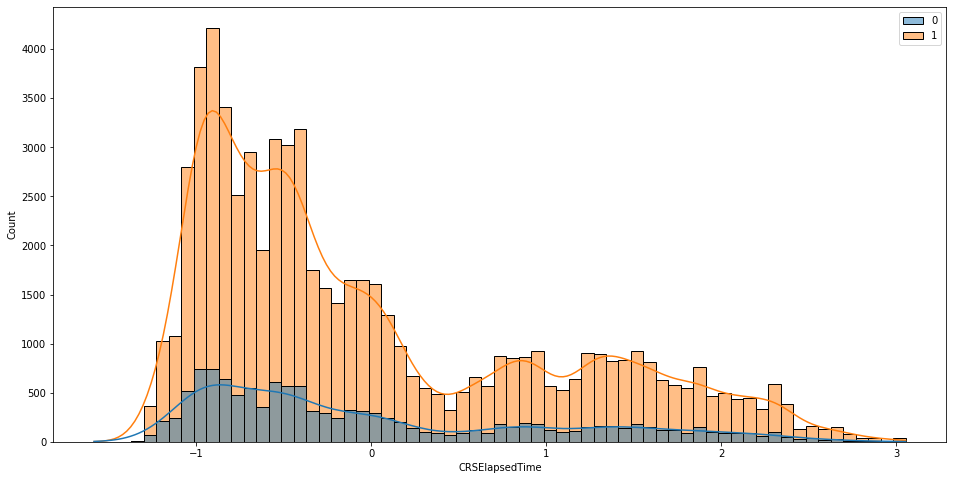

In [46]:
plt.figure(figsize=(16,8))
sns.histplot(data=X_train, x='CRSElapsedTime', hue= y, kde=True)

Introduzcamos en la columna **'Cluster'** el resultado de la clusterizacion de los datos de entreno **X_train** con **Kmeans**

In [47]:
kmeans = KMeans()

In [48]:
X_train['Cluster'] = kmeans.fit_predict(X_train)

In [49]:
X_train.sample(10)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance,Cluster
38840,-0.697276,-1.134913,-0.167605,0.769557,-0.439735,1.546135,1.154586,3
31541,-0.962006,-1.192993,-1.017011,-0.730016,0.426447,0.136017,-0.775879,1
3413,0.865225,0.736552,0.763438,-0.510847,-0.506365,0.584691,-0.511739,2
70149,-0.187722,-0.306736,-0.336709,-0.983789,0.359817,-0.355388,-1.023158,4
25196,-0.159855,-0.156158,0.139503,0.804162,1.692405,-0.697234,0.665647,0
13374,-0.691305,-0.736958,-0.222029,2.695931,-0.439735,-0.633138,2.740826,3
50442,-0.565907,-0.747713,-0.566068,-0.441636,0.426447,-0.034906,-0.614304,1
23828,-0.303168,-0.366967,-0.395021,-1.006860,-0.239847,-0.141733,-0.997868,4
75982,1.414589,1.543218,1.389316,-0.660804,-0.839511,-0.675869,-0.590419,2
37402,1.671357,1.822863,-1.792556,1.334780,-0.373106,-0.697234,1.696914,5


De acuerdo a la clusterizacion calculada en kmeans, hagamos una prediccion de a que cluster pertenecerian los datos de **X_test** e incluyamoslo en la columna **'Cluster'** en los datos de test

In [50]:
X_test['Cluster'] = kmeans.predict(X_test)

In [51]:
kmeans.n_clusters

8

In [52]:
X_test.sample(10)

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance,Cluster
16686,1.661404,1.596996,1.393203,-0.926113,0.293188,0.584691,-0.906543,2
2870,-0.928168,-0.988638,-0.566068,0.388896,0.826223,-0.675869,0.197784,1
7597,0.094922,-0.113136,0.155053,2.049961,1.159370,0.755614,2.015848,0
4288,0.648266,0.317086,0.364975,-0.626199,1.159370,1.567500,-0.590419,6
18862,0.208377,0.155753,0.419399,0.100517,-0.839511,-0.697234,-0.021396,4
5041,-0.177769,-0.328247,0.431061,0.458107,0.026670,-0.034906,0.830032,0
274,-0.559935,-0.607891,-0.566068,-0.730016,-0.706253,-0.504945,-0.796954,4
3815,1.096117,1.005441,1.109420,-0.360890,-0.173218,0.392402,-0.334710,2
19292,-1.378009,-1.575891,-1.368825,-0.764621,-0.239847,-0.526311,-0.700009,1
9743,-1.290430,-1.468335,-1.143353,-0.003300,-0.772882,0.200113,-0.147845,1


In [53]:
X_train["Cluster"].dtype

dtype('int32')

Obsevemos la division en los clusters calculados en el histograma anteriormente graficado

<AxesSubplot:xlabel='CRSElapsedTime', ylabel='Count'>

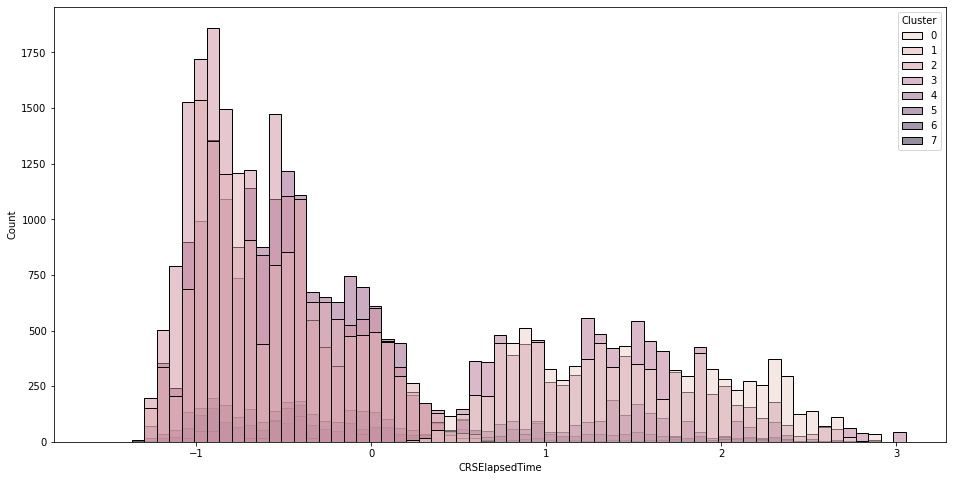

In [54]:
plt.figure(figsize=(16,8))
sns.histplot(data=X_train, x='CRSElapsedTime', hue= 'Cluster')

Veamos si podemos mejorar las predicciones del modelo **XGBoost**. Usemos la matriz de caracteristicas original con la columna añadida con los datos de los clusters obtenidos con Kmeans

In [55]:
xgb_clas4 = xgb.XGBClassifier(use_label_encoder=False, booster= 'gbtree',
                              n_estimators=1000, max_depth=7, learning_rate=0.1, 
                              gamma= 0.1, objective= 'binary:logistic', eval_metric='logloss',
                              random_state=33, verbosity=0, n_jobs=4, )

xgb_clas4.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.63057
[1]	validation_0-logloss:0.57920
[2]	validation_0-logloss:0.53631
[3]	validation_0-logloss:0.50027
[4]	validation_0-logloss:0.46945
[5]	validation_0-logloss:0.44303
[6]	validation_0-logloss:0.42025
[7]	validation_0-logloss:0.40040
[8]	validation_0-logloss:0.38317
[9]	validation_0-logloss:0.36809
[10]	validation_0-logloss:0.35472
[11]	validation_0-logloss:0.34293
[12]	validation_0-logloss:0.33273
[13]	validation_0-logloss:0.32354
[14]	validation_0-logloss:0.31549
[15]	validation_0-logloss:0.30834
[16]	validation_0-logloss:0.30199
[17]	validation_0-logloss:0.29591
[18]	validation_0-logloss:0.29063
[19]	validation_0-logloss:0.28599
[20]	validation_0-logloss:0.28194
[21]	validation_0-logloss:0.27799
[22]	validation_0-logloss:0.27453
[23]	validation_0-logloss:0.27148
[24]	validation_0-logloss:0.26872
[25]	validation_0-logloss:0.26603
[26]	validation_0-logloss:0.26393
[27]	validation_0-logloss:0.26204
[28]	validation_0-logloss:0.26021
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [56]:
# Predict
y_xgb4_pred = xgb_clas4.predict(X_test)

xgb4_conf_M = metrics.confusion_matrix(y_test, y_xgb4_pred)

print('XGBoost2: ')
print(xgb2_conf_M)
print('XGBoost 4: ')
print(xgb4_conf_M)

acc_xgb4 = round(metrics.accuracy_score(y_test, y_xgb4_pred),4)
pre_xgb4 = round(metrics.precision_score(y_test, y_xgb4_pred),4)
rec_xgb4 = round(metrics.recall_score(y_test, y_xgb4_pred),4)

print("XGBoost2  | Accuracy:", acc_xgb2, ' | ', "Precision:", pre_xgb2, ' | ', "Recall:", rec_xgb2)
print("XGBoost4 | Accuracy:", acc_xgb4,' | ', "Precision:", pre_xgb4,' | ', "Recall:", rec_xgb4)

XGBoost2: 
[[ 1576  1361]
 [  801 15864]]
XGBoost 4: 
[[ 1551  1386]
 [  813 15852]]
XGBoost2  | Accuracy: 0.8897  |  Precision: 0.921  |  Recall: 0.9519
XGBoost4 | Accuracy: 0.8878  |  Precision: 0.9196  |  Recall: 0.9512


No obtenemos una mejora.

En el histograma de **CRSELapsedTime** hemos visto como para **CRSELapsedTime<0.5** se observaba una mayoria de vuelos en los que se observaba retraso. Incluyamos una columna llamada **'ShortTrip'** para esos vuelos y veamos si la introduccion de dicha variable mejora las predicciones.

In [57]:
X_train['ShortTrip']= X_train['CRSElapsedTime']<0.5
Short_trip_list = [int(k) for k in X_train['ShortTrip'] ]
X_train['ShortTrip'] = pd.Series(Short_trip_list)
X_train.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance,Cluster,ShortTrip
0,1.496197,1.618507,-2.091889,1.115612,-0.439735,-0.547676,1.560630,5,0
1,-0.956034,-1.027358,-0.801258,1.738511,2.025552,-0.590407,1.557820,3,0
2,-1.117261,-1.575891,-1.331894,-0.545453,-0.772882,1.417942,-0.593229,1,1
3,1.426531,1.199041,1.002515,-1.110676,0.093300,1.161557,-0.997868,2,1
4,-1.481513,-1.586646,-1.357163,-0.637734,-0.439735,-0.675869,-0.614304,1,1


In [58]:
X_test['ShortTrip']= X_test['CRSElapsedTime']<0.5
Short_trip_list2 = [int(k) for k in X_test['ShortTrip'] ]
X_test['ShortTrip'] = pd.Series(Short_trip_list2)
X_test.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance,Cluster,ShortTrip
0,-0.884378,-1.145669,-0.818752,-0.960719,-0.572994,0.499229,-0.930428,1,1
1,1.715146,1.827165,-1.798387,1.277104,-0.106588,-0.269926,1.601375,5,0
2,-1.346162,-1.597402,-1.190003,1.334780,0.626335,0.029190,1.134916,3,0
3,-1.553169,-1.812513,-1.697314,-0.983789,-0.639623,-0.056272,-0.900923,1,1
4,-0.894331,-1.167180,-0.774046,0.112052,0.626335,0.606056,-0.064951,1,1


Volvemos a usar el modelo XGBoost para obtener las predicciones, esta vez con la columna **'ShortTrip'** añadida.

In [59]:
xgb_clas5 = xgb.XGBClassifier(use_label_encoder=False, booster= 'gbtree',
                              n_estimators=1000, max_depth=7, learning_rate=0.1, 
                              gamma= 0.1, objective= 'binary:logistic', eval_metric='logloss',
                              random_state=33, verbosity=0, n_jobs=4, )

xgb_clas5.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.63057
[1]	validation_0-logloss:0.57920
[2]	validation_0-logloss:0.53631
[3]	validation_0-logloss:0.50027
[4]	validation_0-logloss:0.46945
[5]	validation_0-logloss:0.44303
[6]	validation_0-logloss:0.42025
[7]	validation_0-logloss:0.40040
[8]	validation_0-logloss:0.38317
[9]	validation_0-logloss:0.36809
[10]	validation_0-logloss:0.35472
[11]	validation_0-logloss:0.34293
[12]	validation_0-logloss:0.33273
[13]	validation_0-logloss:0.32354
[14]	validation_0-logloss:0.31549
[15]	validation_0-logloss:0.30834
[16]	validation_0-logloss:0.30199
[17]	validation_0-logloss:0.29591
[18]	validation_0-logloss:0.29063
[19]	validation_0-logloss:0.28599
[20]	validation_0-logloss:0.28194
[21]	validation_0-logloss:0.27799
[22]	validation_0-logloss:0.27453
[23]	validation_0-logloss:0.27148
[24]	validation_0-logloss:0.26872
[25]	validation_0-logloss:0.26603
[26]	validation_0-logloss:0.26393
[27]	validation_0-logloss:0.26204
[28]	validation_0-logloss:0.26021
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [60]:
# Predict
y_xgb5_pred = xgb_clas5.predict(X_test)

xgb5_conf_M = metrics.confusion_matrix(y_test, y_xgb5_pred)

print('XGBoost2: ')
print(xgb2_conf_M)
print('XGBoost 5: ')
print(xgb5_conf_M)

acc_xgb5 = round(metrics.accuracy_score(y_test, y_xgb5_pred),4)
pre_xgb5 = round(metrics.precision_score(y_test, y_xgb5_pred),4)
rec_xgb5 = round(metrics.recall_score(y_test, y_xgb5_pred),4)

print("XGBoost2  | Accuracy:", acc_xgb2, ' | ', "Precision:", pre_xgb2, ' | ', "Recall:", rec_xgb2)
print("XGBoost5 | Accuracy:", acc_xgb5,' | ', "Precision:", pre_xgb5,' | ', "Recall:", rec_xgb5)

XGBoost2: 
[[ 1576  1361]
 [  801 15864]]
XGBoost 5: 
[[ 1551  1386]
 [  813 15852]]
XGBoost2  | Accuracy: 0.8897  |  Precision: 0.921  |  Recall: 0.9519
XGBoost5 | Accuracy: 0.8878  |  Precision: 0.9196  |  Recall: 0.9512


De nuevo observamos como no obtenemos mejora en las predicciones.

In [61]:
# Crea una instancia del modelo de Regresion Logistica 
log_reg3 = LogisticRegression(penalty='elasticnet', solver='saga',  tol=0.0001,
                             max_iter=200, l1_ratio=0.8, C=0.05,
                             verbose=2, random_state=33)

# Entrena el modelo con los datos de train
log_reg3.fit(X_train,y_train)

# Realiza las predicciones a partir de los datos de test
y_log3_pred = log_reg3.predict(X_test)

log_conf_M3 = metrics.confusion_matrix(y_test, y_log3_pred)

print('Conf Matrix Log Regr 2: ')
print(log_conf_M2)

print('Conf Matrix Log. Regr 3: ')
print(log_conf_M3)

acc_log3 = round(metrics.accuracy_score(y_test, y_log3_pred),4)
pre_log3 = round(metrics.precision_score(y_test, y_log3_pred),4)
rec_log3 = round(metrics.recall_score(y_test, y_log3_pred),4)

print("Log Reg 2 | Accuracy:", acc_log2, ' | ', "Precision:", pre_log2, ' | ', "Recall:", rec_log2)
print("Log Reg 3 | Accuracy:", acc_log3,' | ', "Precision:", pre_log3,' | ', "Recall:", rec_log3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds
Conf Matrix Log Regr 2: 
[[ 1062  1875]
 [  654 16011]]
Conf Matrix Log. Regr 3: 
[[ 1061  1876]
 [  648 16017]]
Log Reg 2 | Accuracy: 0.871  |  Precision: 0.8952  |  Recall: 0.9608
Log Reg 3 | Accuracy: 0.8712  |  Precision: 0.8952  |  Recall: 0.9611


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


**Obtenemos mejora en el modelo de Regresion Logistica. Los TP pasan de 16011 a 16020 y los FN de 654 a 648.**

--------------

## Ejercicio 6

No uses la variable **'DepDelay'** para hacer las predicciones.

----------------

In [62]:
X_train.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,DepDelay,Distance,Cluster,ShortTrip
0,1.496197,1.618507,-2.091889,1.115612,-0.439735,-0.547676,1.560630,5,0
1,-0.956034,-1.027358,-0.801258,1.738511,2.025552,-0.590407,1.557820,3,0
2,-1.117261,-1.575891,-1.331894,-0.545453,-0.772882,1.417942,-0.593229,1,1
3,1.426531,1.199041,1.002515,-1.110676,0.093300,1.161557,-0.997868,2,1
4,-1.481513,-1.586646,-1.357163,-0.637734,-0.439735,-0.675869,-0.614304,1,1


In [63]:
X_train.drop( columns= 'DepDelay', inplace= True )
X_test.drop( columns= 'DepDelay', inplace= True )

In [64]:
X_train.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,Distance,Cluster,ShortTrip
0,1.496197,1.618507,-2.091889,1.115612,-0.439735,1.560630,5,0
1,-0.956034,-1.027358,-0.801258,1.738511,2.025552,1.557820,3,0
2,-1.117261,-1.575891,-1.331894,-0.545453,-0.772882,-0.593229,1,1
3,1.426531,1.199041,1.002515,-1.110676,0.093300,-0.997868,2,1
4,-1.481513,-1.586646,-1.357163,-0.637734,-0.439735,-0.614304,1,1


In [65]:
X_test.head()

,DepTime,CRSDepTime,CRSArrTime,CRSElapsedTime,TaxiOut,Distance,Cluster,ShortTrip
0,-0.884378,-1.145669,-0.818752,-0.960719,-0.572994,-0.930428,1,1
1,1.715146,1.827165,-1.798387,1.277104,-0.106588,1.601375,5,0
2,-1.346162,-1.597402,-1.190003,1.334780,0.626335,1.134916,3,0
3,-1.553169,-1.812513,-1.697314,-0.983789,-0.639623,-0.900923,1,1
4,-0.894331,-1.167180,-0.774046,0.112052,0.626335,-0.064951,1,1


In [66]:
xgb_clas_n = xgb.XGBClassifier(use_label_encoder=False, booster= 'gbtree',
                              n_estimators=1000, max_depth=7, learning_rate=0.1, 
                              gamma= 0.1, objective= 'binary:logistic', eval_metric='logloss',
                              random_state=33, verbosity=0, n_jobs=4, )

xgb_clas_n.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

# Predict
y_xgb_n_pred = xgb_clas_n.predict(X_test)

[0]	validation_0-logloss:0.64135
[1]	validation_0-logloss:0.59919
[2]	validation_0-logloss:0.56427
[3]	validation_0-logloss:0.53511
[4]	validation_0-logloss:0.51031
[5]	validation_0-logloss:0.48923
[6]	validation_0-logloss:0.47117
[7]	validation_0-logloss:0.45582
[8]	validation_0-logloss:0.44275
[9]	validation_0-logloss:0.43133
[10]	validation_0-logloss:0.42149
[11]	validation_0-logloss:0.41298
[12]	validation_0-logloss:0.40564
[13]	validation_0-logloss:0.39916
[14]	validation_0-logloss:0.39360
[15]	validation_0-logloss:0.38864
[16]	validation_0-logloss:0.38422
[17]	validation_0-logloss:0.38057
[18]	validation_0-logloss:0.37722
[19]	validation_0-logloss:0.37435
[20]	validation_0-logloss:0.37176
[21]	validation_0-logloss:0.36934
[22]	validation_0-logloss:0.36640
[23]	validation_0-logloss:0.36452
[24]	validation_0-logloss:0.36284
[25]	validation_0-logloss:0.36038
[26]	validation_0-logloss:0.35878
[27]	validation_0-logloss:0.35740
[28]	validation_0-logloss:0.35631
[29]	validation_0-loglos

[238]	validation_0-logloss:0.24677
[239]	validation_0-logloss:0.24670
[240]	validation_0-logloss:0.24672
[241]	validation_0-logloss:0.24661
[242]	validation_0-logloss:0.24661
[243]	validation_0-logloss:0.24644
[244]	validation_0-logloss:0.24645
[245]	validation_0-logloss:0.24635
[246]	validation_0-logloss:0.24622
[247]	validation_0-logloss:0.24621
[248]	validation_0-logloss:0.24594
[249]	validation_0-logloss:0.24583
[250]	validation_0-logloss:0.24567
[251]	validation_0-logloss:0.24561
[252]	validation_0-logloss:0.24520
[253]	validation_0-logloss:0.24507
[254]	validation_0-logloss:0.24504
[255]	validation_0-logloss:0.24505
[256]	validation_0-logloss:0.24503
[257]	validation_0-logloss:0.24497
[258]	validation_0-logloss:0.24490
[259]	validation_0-logloss:0.24488
[260]	validation_0-logloss:0.24482
[261]	validation_0-logloss:0.24477
[262]	validation_0-logloss:0.24468
[263]	validation_0-logloss:0.24464
[264]	validation_0-logloss:0.24457
[265]	validation_0-logloss:0.24452
[266]	validation_0-l

[473]	validation_0-logloss:0.23714
[474]	validation_0-logloss:0.23714
[475]	validation_0-logloss:0.23715
[476]	validation_0-logloss:0.23716
[477]	validation_0-logloss:0.23714
[478]	validation_0-logloss:0.23714
[479]	validation_0-logloss:0.23718
[480]	validation_0-logloss:0.23722
[481]	validation_0-logloss:0.23713
[482]	validation_0-logloss:0.23705
[483]	validation_0-logloss:0.23701
[484]	validation_0-logloss:0.23697
[485]	validation_0-logloss:0.23696
[486]	validation_0-logloss:0.23697
[487]	validation_0-logloss:0.23696
[488]	validation_0-logloss:0.23696
[489]	validation_0-logloss:0.23689
[490]	validation_0-logloss:0.23693
[491]	validation_0-logloss:0.23694
[492]	validation_0-logloss:0.23691
[493]	validation_0-logloss:0.23688
[494]	validation_0-logloss:0.23688
[495]	validation_0-logloss:0.23687
[496]	validation_0-logloss:0.23688
[497]	validation_0-logloss:0.23688
[498]	validation_0-logloss:0.23684
[499]	validation_0-logloss:0.23681
[500]	validation_0-logloss:0.23680
[501]	validation_0-l

In [67]:
dec_tree_n = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=60, min_samples_leaf=20)

# Train modelo with train data
dec_tree_n.fit(X_train,y_train)

y_tree_n_pred = dec_tree_n.predict(X_test)

In [68]:
# Crea una instancia del modelo de Regresion Logistica 
log_reg_n = LogisticRegression(penalty='elasticnet', solver='saga',  tol=0.0001,
                             max_iter=200, l1_ratio=0.8, C=0.05,
                             verbose=2, random_state=33)

# Entrena el modelo con los datos de train
log_reg_n.fit(X_train,y_train)

# Realiza las predicciones a partir de los datos de test
y_log_n_pred = log_reg_n.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 12 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [69]:
#Obtencion de metricas
acc_log_n = round(metrics.accuracy_score(y_test, y_log_n_pred),4)
pre_log_n = round(metrics.precision_score(y_test, y_log_n_pred),4)
rec_log_n = round(metrics.recall_score(y_test, y_log_n_pred),4)
                
acc_tree_n = round(metrics.accuracy_score(y_test, y_tree_n_pred),4)
pre_tree_n = round(metrics.precision_score(y_test, y_tree_n_pred),4)  
rec_tree_n = round(metrics.recall_score(y_test, y_tree_n_pred),4)
                
acc_xgb_n = round(metrics.accuracy_score(y_test, y_xgb_n_pred),4)
pre_xgb_n = round(metrics.precision_score(y_test, y_xgb_n_pred),4)
rec_xgb_n = round(metrics.recall_score(y_test, y_xgb_n_pred),4)

log_n_conf_M = metrics.confusion_matrix(y_test, y_log_n_pred)
tree_n_conf_M = metrics.confusion_matrix(y_test, y_tree_n_pred)
xgb_n_conf_M = metrics.confusion_matrix(y_test, y_xgb_n_pred)

#Impresion de resultados
print('Matrices de Confianza:')
print('Logistic Regression n: ')
print(log_n_conf_M)

print('Decision Tree n: ')
print(tree_n_conf_M)

print('XGBoost n: ')
print(xgb_n_conf_M)

print("Log Reg. n| Accuracy:", acc_log_n, ' | ', "Precision:", pre_log_n, ' | ', "Recall:", rec_log_n)
print("Dec Tree n| Accuracy:", acc_tree_n,' | ', "Precision:", pre_tree_n,' | ', "Recall:", rec_tree_n)
print("XGBoost  n| Accuracy:", acc_xgb_n, ' | ', "Precision:", pre_xgb_n, ' | ', "Recall:", rec_xgb_n)

Matrices de Confianza:
Logistic Regression n: 
[[   41  2896]
 [   57 16608]]
Decision Tree n: 
[[  275  2662]
 [  186 16479]]
XGBoost n: 
[[ 1398  1539]
 [  726 15939]]
Log Reg. n| Accuracy: 0.8494  |  Precision: 0.8515  |  Recall: 0.9966
Dec Tree n| Accuracy: 0.8547  |  Precision: 0.8609  |  Recall: 0.9888
XGBoost  n| Accuracy: 0.8845  |  Precision: 0.9119  |  Recall: 0.9564


Sorprendentemente obtenemos los mejores resultados sin la variable mas predictora **'DepDelay'** pero con las columnas introducidas de **'Cluster'** y **'ShortTrip'**. 

De acuerdo a los criterios establecidos el modelo Decision Tree obtiene una mejora notable

El modelo de **Regresion Logistica** obtiene el **mejor resultado** de todos. 

**Del total de casos positivos solo clasifica mal 55 !  y obtenemos el maximo de casos positivos ( FN=55, TP=16610)**